In [8]:
# Wavelet transform and Mass mapping jupyter notebook
# Experiment 1: 
#     - Take the starlet transform of an image
#     - Caculate the standard deviation of each wavelet scale
#     - Reconstruct an image from its coefficients and check that the reconstruction is exact
# Experiment 2: inpainting a convergence map using the Discrete Cosine Transform
# Experiment 3: Gaussian Denoising
#      - Create a 2D Gaussian in a 2D image
#      - Add some Gaussian noise to the image.
#      - Perform a wavelet thresholding
#      - Check if the Gaussian is detected.
#      - Reconstruct a denoising image from the thresholded coefficients
# Experiment 4: Do mass map reconstruction with different methods on COSMOS data
#      - Kaiser-Squires
#      - Proximal Wiener
#      - Sparsity
#      - MCAlens

In [9]:
print("Hello")
from astropy.io import fits
import math
import pysap
from pysap.extensions import sparse2d
import pycs
import numpy as np
from pysap import Image
from pysap.data import get_sample_data
from pycs.misc.cosmostat_init import *
from pycs.misc.mr_prog import *
from pycs.misc.im1d_tend import *
from pycs.misc.utilHSS import *
from pycs.misc.stats import *
from pycs.sparsity.sparse2d.dct import dct2d, idct2d
from pycs.sparsity.sparse2d.dct_inpainting import dct_inpainting
from pycs.sparsity.sparse2d.starlet import *

Hello


ModuleNotFoundError: No module named 'pysap'

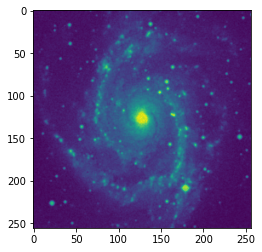

In [3]:
# Experiment 1: 
#     - Take the starlet transform of an image
#     - Caculate the standard deviation of each wavelet scale
#     - Reconstruct an image from its coefficients and check that the reconstruction is exact

galaxy = get_sample_data('astro-ngc2997')

# galaxy.show()
g= galaxy.data
(nx,ny) = g.shape
plt.imshow(g)
plt.show() 
(nx,ny)
mask = np.zeros((nx,ny))

In [4]:
# Display the scales.
nscale=4
w=star2d(g,nscale)
w.shape

(4, 256, 256)

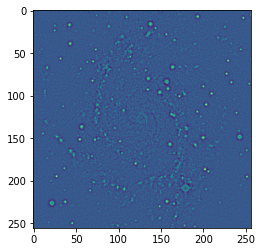

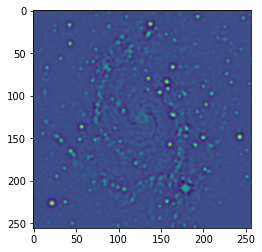

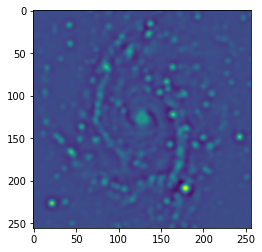

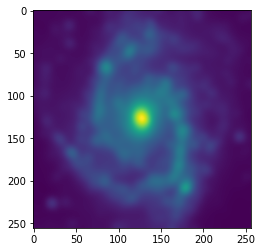

In [5]:
plt.imshow(w[0,:,:])
plt.show() 
plt.imshow(w[1,:,:])
plt.show() 
plt.imshow(w[2,:,:])
plt.show() 
plt.imshow(w[3,:,:])
plt.show()

In [6]:
for i in np.arange(nscale):
    s = w[i,:,:]
    print("Scale %2d: Min = %f, Max = %f, Mean = %f, std = %f" % (i+1,s.min(), s.max(), s.mean(), s.std()))


Scale  1: Min = -293.953125, Max = 763.144531, Mean = 0.004349, std = 61.602379
Scale  2: Min = -274.966309, Max = 879.045410, Mean = 0.018928, std = 66.078265
Scale  3: Min = -256.354126, Max = 848.200562, Mean = 0.079316, std = 62.417015
Scale  4: Min = 255.659271, Max = 2867.816650, Mean = 632.576133, std = 347.863982


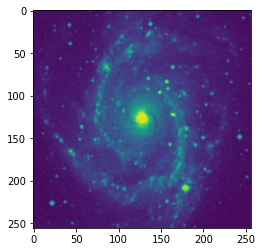

Residual  4: Min = 0.000000, Max = 0.000000, Mean = 0.000000, std = 0.000000


In [7]:
#Reconstruction
r= np.sum(w,axis=0)
plt.imshow(r)
plt.show() 
resi=g-r
print("Residual %2d: Min = %f, Max = %f, Mean = %f, std = %f" % (i+1,resi.min(), resi.max(), resi.mean(), resi.std()))

Image size =  (512, 512)


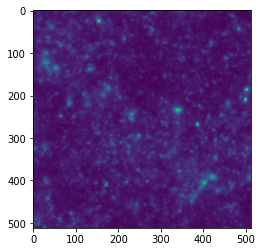

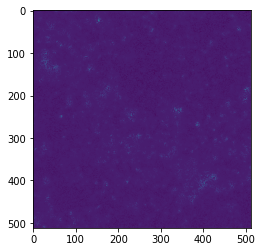

Masked data: Min = -0.010429, Max = 0.121893


In [8]:
# Experiment 2: inpainting a convergence map using the Discrete Cosine Transform
 
g = readfits("WLconv_z0.50_3316r.fits")
print("Image size = ", g.shape)
plt.imshow(g)
plt.show()

# Create a mask m, with only 20% of pixels:
m = np.random.choice([1, 0], size=(512,512), p=[0.2, 0.8])

# apply the mask to the galaxy
d= m * g

plt.imshow(d)
plt.show()
print("Masked data: Min = %f, Max = %f" % (d.min(), d.max()))

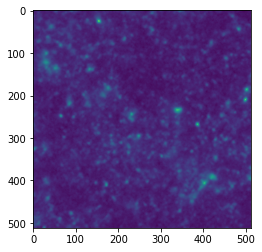

In [9]:
# DCT inpainting Experiments
from scipy.special import erf

def dct_inpaint(image, mask, niter=100):
    # Enforce binary mask condition
    mask = mask.astype(bool).astype(float)

    # Set threshold limits
    lmax = np.max(np.abs(dct2d(image, norm='ortho')))
    lmin = 0

    # Do iterative inpainting
    result = np.zeros_like(image)
    for ii in range(niter):
        # Compute residual
        residual = image - result
        # Take a step
        update = result + mask * residual
        # Change basis with DCT
        alpha = dct2d(update, norm='ortho')
        # Threshold coefficients
        # lval = lmax - ii * (lmax - lmin) / (niter - 1)  # linear decay
        lval = lmin + (lmax - lmin) * (1 - erf(2.8 * ii / niter))  # exp decay
        new_alpha = np.copy(alpha)  # Can we do this without copying ?
        new_alpha[np.abs(new_alpha) <= lval] = 0
         
        # Go back to direct space
        result = idct2d(new_alpha, norm='ortho')
        # Enforce std. dev. constraint inside the mask
        std_out = result[mask.astype(bool)].std()
        std_in = result[~mask.astype(bool)].std()
        if std_in != 0:
            result[~mask.astype(bool)] *= std_out / std_in
    return result

# Call the DCT inpainting technique
inpd = dct_inpaint(d, m)
plt.imshow(inpd)
plt.show()

In [10]:
# Experiment 3: Gaussian Denoising
#      - Create a 2D Gaussian in a 2D image
#      - Add some Gaussian noise to the image.
#      - Perform a wavelet thresholding
#      - Check if the Gaussian is detected.
#      - Reconstruct a denoising image from the thresholded coefficients

def makeGaussian(size, fwhm = 20, center=None):
    """ Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

dim=256
n = np.random.normal(0,1,(dim,dim))
nscale=5
w=star2d(n,nscale)
TabNorm = np.zeros((nscale))
for i in np.arange(nscale):
    s = w[i,:,:]
    TabNorm[i] = s.std()
    print("Scale %2d: Min = %f, Max = %f, Mean = %f, std = %f" % (i+1,s.min(), s.max(), s.mean(), s.std()))
print("TabNorm=", TabNorm)

Scale  1: Min = -4.123871, Max = 3.785617, Mean = -0.000034, std = 0.890053
Scale  2: Min = -0.855207, Max = 0.802374, Mean = -0.000027, std = 0.202579
Scale  3: Min = -0.343850, Max = 0.325599, Mean = 0.000083, std = 0.087218
Scale  4: Min = -0.218482, Max = 0.170241, Mean = 0.000124, std = 0.042726
Scale  5: Min = -0.148631, Max = 0.139135, Mean = -0.000420, std = 0.035781
TabNorm= [0.8900531  0.20257908 0.08721803 0.04272593 0.03578134]


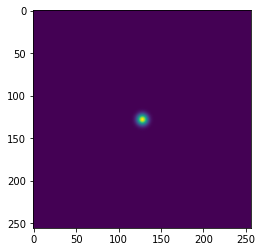

Data: Min = 0.000000, Max = 1.000000


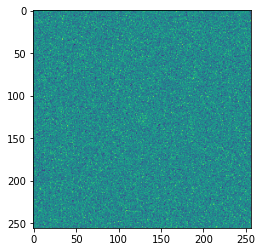

In [11]:
dim=256  # image size
Fwhm=10  # Full width at half maximum of the Gaussian
nscale=5 # Number of wavelet scales in the analysis

g = makeGaussian(dim, fwhm = Fwhm)
plt.imshow(g)
plt.show()
print("Data: Min = %f, Max = %f" % (g.min(), g.max()))

PSNR=1.   # Peak noise level. PSNR=1 ==> noise standard deviation = max of the Gaussian
NoiseLevel = 1. / PSNR
# noise realisation
n = np.random.normal(0,NoiseLevel,(dim,dim))

# add the noise to the Gaussian image and plot it
gn = g + n
plt.imshow(gn)
plt.show()

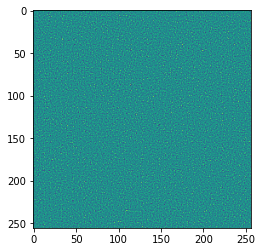

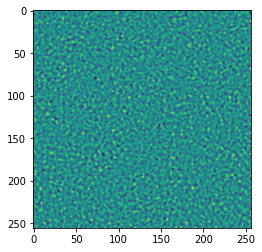

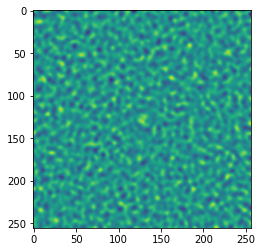

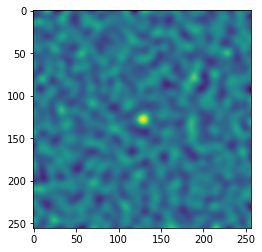

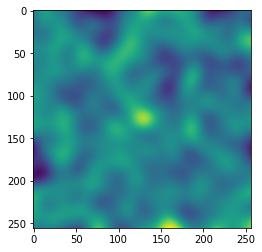

In [12]:
# Take the starlet transform of the noise image and dispay the scales
w=star2d(gn,nscale)
plt.imshow(w[0,:,:])
plt.show() 
plt.imshow(w[1,:,:])
plt.show() 
plt.imshow(w[2,:,:])
plt.show() 
plt.imshow(w[3,:,:])
plt.show()
plt.imshow(w[4,:,:])
plt.show()

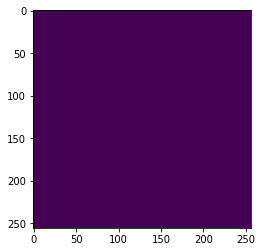

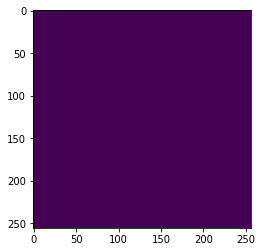

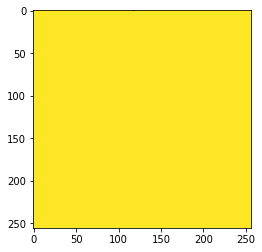

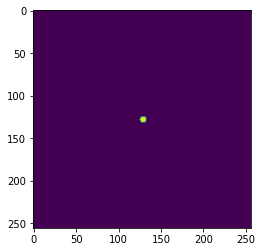

In [13]:
# Hard thresholding routine
def hthres(alpha,Thres):
    Res = np.copy(alpha)
    Res[np.abs(Res) <= Thres] = 0
    return Res


KSigma=5 # Apply a threshold at 5 sigma the noise level


TabThreshold = NoiseLevel * TabNorm * KSigma  # TabThreshold[i] = Threshold level at scale i
for i in np.arange(nscale-1):
    s = w[i,:,:]   # get the wavelet scale i
    st = hthres(s,TabThreshold[i])  # thresholding
    w[i,:,:] = st  # put the thresholded scale back in the wavelet cube
    plt.imshow(w[i,:,:])  # show the thresholded scale
    plt.show() 

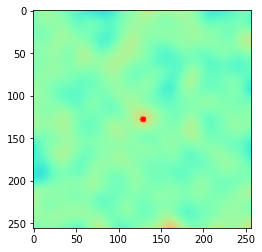

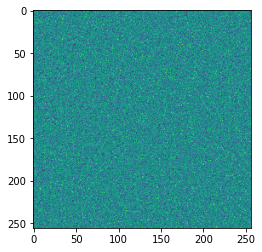

In [14]:
# reconstruct the image from its thresholded coefficients
r= np.sum(w,axis=0)
resi=gn-r
plt.imshow(r, cmap='rainbow')
plt.show()
plt.imshow(resi)
plt.show()

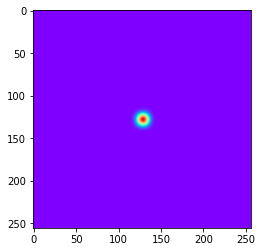

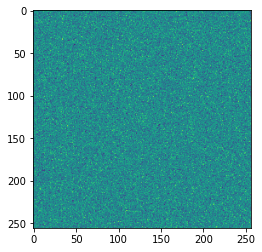

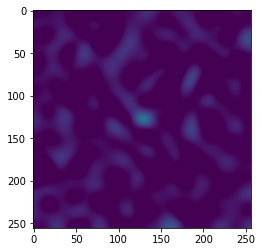

In [15]:
# Use the C++ program mr_filter with an iterative hard thresholding
fgn = mr_prog(gn, prog="mr_filter ", opt=" -v -n5 -s5 -g1. -K -A -f3 ")
plt.imshow(fgn,cmap='rainbow')
plt.show()
plt.imshow(gn-fgn)
plt.show()

fgn = mr_prog(gn, prog="mr_filter ", opt=" -v -n5 -s5 -g1. -t24 ")
plt.imshow(fgn)
plt.show()

In [16]:
# Experiment 4: Do mass map reconstruction with different methods on COSMOS data
# Routine for COSMOS EXPERIMENT

# Need the following routines
from lenspack.utils import bin2d
from lenspack.image.inversion import ks93
from lenspack.geometry.projections import gnom
from pycs.astro.wl.mass_mapping import *
import footprint
from footprint import draw_footprint
from pycs.misc.im_isospec import *
import sys  
# Function for drawing the data footprint
cosmos_vertices = np.load("footprint.npy")
DEF_lut='inferno'

def draw_footprint(ax, c='w', lw=1, **kwargs):
    ra, dec = cosmos_vertices.T
    ax.plot(ra, dec, c=c, lw=lw, **kwargs)
    
def get_extend_radec():
    ra0, dec0 = (150.11, 2.24) # from cosmos.astro.caltech.edu (could also just use the medians of positions)
    proj = gnom.projector(ra0, dec0)
    dx = np.deg2rad(1.5) / 2. # 1.5 degrees across
    dy = dx
    extent_xy = [-dx, dx, -dy, dy]
    ra_min, dec_min = proj.xy2radec(-dx, -dy)
    ra_max, dec_max = proj.xy2radec(dx, dy)
    extent_radec = [ra_min, ra_max, dec_min, dec_max]
    return extent_radec
    
def tvradec(ima, title='ima',vmin=None,vmax=None,smooth=None,xclus=False,mtext=False,m500min=0, zmin=0.3,zmax=1,ztext=False,lut=DEF_lut,filename=None,extent_radec=None):
    if extent_radec is None:
        extent_radec = get_extend_radec()

    fs = 18 # fontsize        
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    # Kappa map
    if smooth is None:
        imaS = ima
    else:
        imaS = gf(ima, smooth)
    img = ax.imshow(imaS, origin='lower', cmap=lut, vmin=vmin, vmax=vmax, extent=extent_radec)
    draw_footprint(ax)
    
    # Xray clusters
    if xclus:
        xclusters = np.loadtxt("xray.txt")
        highz = (xclusters[:, 6] >= zmin) & (xclusters[:, 6] <= zmax)
        for cluster in xclusters[highz]:
            ra_cl, dec_cl, z_cl = cluster[1], cluster[2], cluster[6]
            m500 = cluster[7]
            if m500 > m500min:
                ax.scatter(ra_cl, dec_cl, c='w', s=12)
                if ztext:
                    ax.text(ra_cl + 0.03, dec_cl + 0.02, "{:.2f}".format(z_cl), fontsize=8, c='w')
                if mtext:
                    ax.text(ra_cl + 0.03, dec_cl - 0.02, "{:.2f}".format(m500), fontsize=8, c='w')

    # Clean up and decorate
    ax.set_aspect('equal')
    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_title(title, fontsize=fs)
    ax.set_xlabel("RA [deg]", fontsize=fs)
    ax.set_ylabel("Dec [deg]", fontsize=fs)
    fig.colorbar(img, ax=ax)
    if filename is not None:
        plt.savefig(filename)
    plt.show()



In [17]:
# Read the COSMOS data. The catalog has already be binned

e1map = readfits('cosmos_g1.fits')  # first component image of the shear
e2map = readfits('cosmos_g2.fits')  # second component image of the shear
galmap = readfits('cosmos_countmap.fits') # number of galaxies per pixel 
ps1d = readfits('cosmos_estimated_signal_powspec.fits') # estimated theoretical power spectrum
pn = readfits('cosmos_estimated_noise_powspec.fits')    # estimated noise power spectrum

(256, 256)


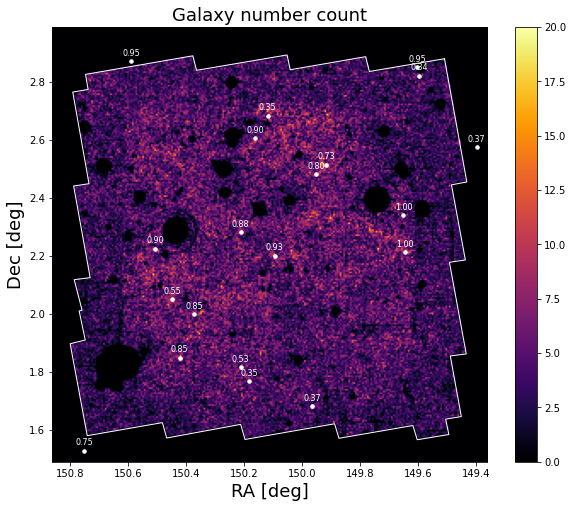

In [21]:
vmin=-0.03
vmax=0.1
zmax=0.99
m500min=3
mtext=False # overplot x-clusters M500
ztext=True # overplot x-clusters redshift
Sigma2Fwhm = 2.355
smooth= 1.2 / Sigma2Fwhm   # resolution in Massey 07 paper
xclus=True # True to overplot x-clusters
print(galmap.shape)
lut=DEF_lut
tvradec(galmap, 'Galaxy number count',lut=lut,xclus=xclus,ztext=ztext,m500min=m500min)

In [22]:
# Create the shear python structure and initiale it with the data
D = shear_data()
D.g1 = e1map
D.g2 = e2map 
SigmaNoise=0.28
(nx,ny) = e1map.shape # assume a diagonal cov mat
ind = np.where(galmap >  0 )
D.mask = np.zeros((nx,ny))
D.mask[ind] = 1

# Create the covariance matrix, assumed to be diagonal
Ncov=np.zeros((nx,ny))
Ncov[ind] = 2. * SigmaNoise**2 / galmap[ind]
Ncov[Ncov==0] = 1e9
D.Ncov = Ncov
D.nx = nx
D.ny = ny

# Create the mass mapping structure and initialise it
M = massmap2d(name='mass')
M.init_massmap(D.nx,D.ny)  
M.DEF_niter=100
Inpaint=False
Bmode=True
g1=D.g1
g2=D.g2

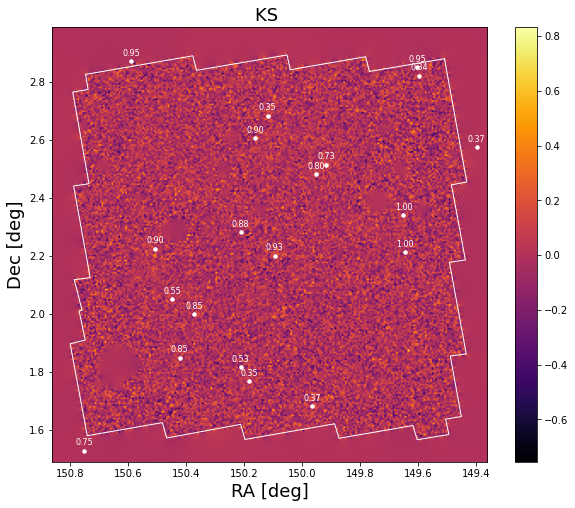

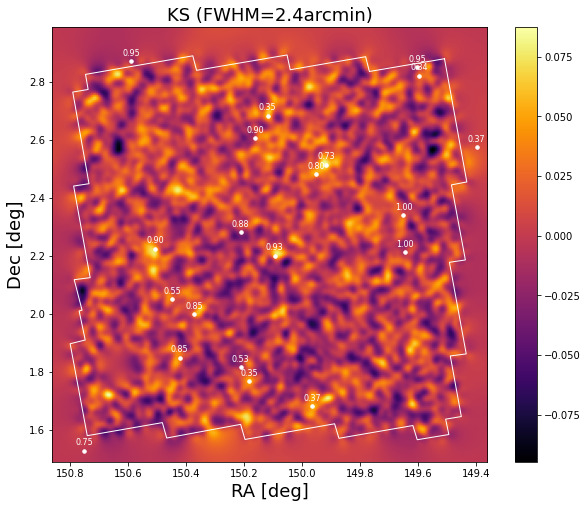

In [23]:
# Calculate the Kaiser-Squires reconstruction, and smooth it
ks =  M.g2k(g1,g2)
ks2 = M.smooth(ks, sigma=2)
tvradec(ks, title='KS ',lut=lut,xclus=xclus,ztext=ztext,m500min=m500min)
tvradec(ks2, title='KS (FWHM=2.4arcmin)',lut=lut,xclus=xclus,ztext=ztext,m500min=m500min)

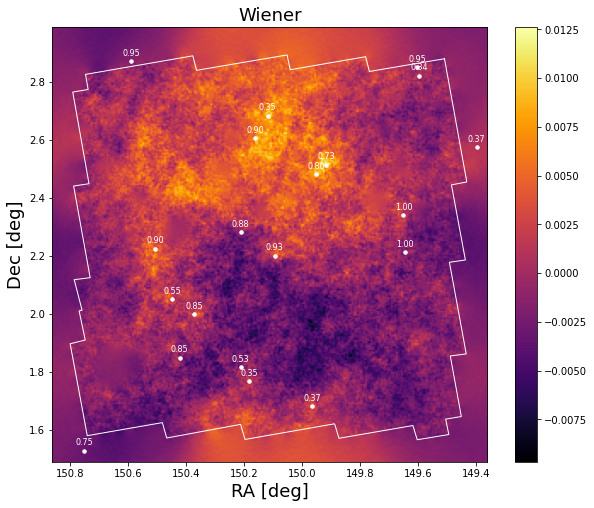

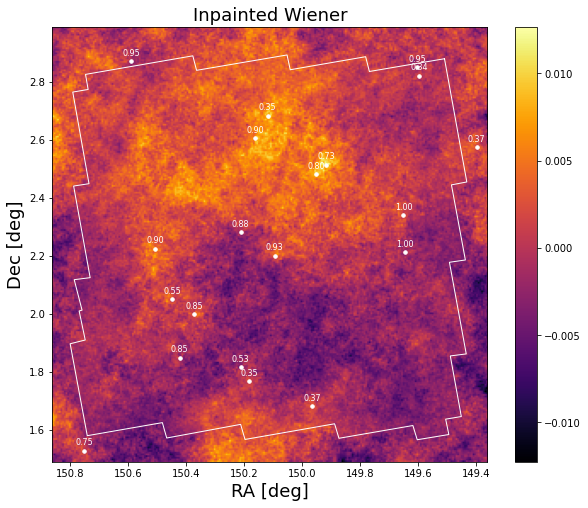

In [24]:
# Perform the proximal wiener filtering
kiw,iwi = M.prox_wiener_filtering(D.g1, D.g2, ps1d, D.Ncov, Inpaint=Inpaint, Pn=pn) #, Pn=Pn) # ,ktr=InShearData.ktr)
tvradec(kiw, title='Wiener',lut=lut,xclus=xclus,ztext=ztext,m500min=m500min)

# Perform the proximal inpainted wiener filtering
kiw,iwi = M.prox_wiener_filtering(D.g1, D.g2, ps1d, D.Ncov, Inpaint=True, Pn=pn) #, Pn=Pn) # ,ktr=InShearData.ktr)
tvradec(kiw, title='Inpainted Wiener',lut=lut,xclus=xclus,ztext=ztext,m500min=m500min)

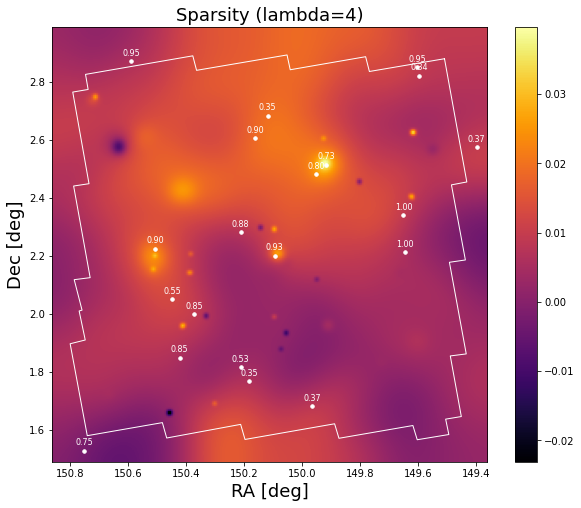

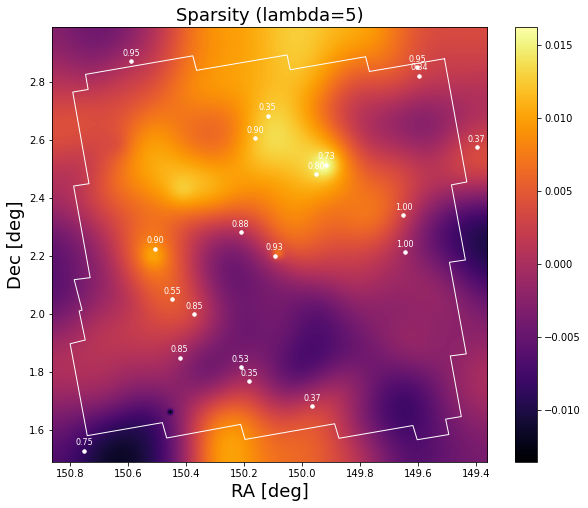

In [25]:
# Do a sparse reconstruction with a 4 sigma detection
ksr4,ti = M.sparse_recons(D, UseNoiseRea=False,Nsigma=4, ThresCoarse=False, Inpaint=False,Nrea=None)
tvradec(ksr4, title='Sparsity (lambda=4)',lut=lut,xclus=xclus,ztext=ztext,m500min=m500min)

# Do a sparse reconstruction with a 5 sigma detection
ksr5,ti = M.sparse_recons(D, UseNoiseRea=False,Nsigma=5, ThresCoarse=False, Inpaint=False,Nrea=None)
tvradec(ksr5, title='Sparsity (lambda=5)',lut=lut,xclus=xclus,ztext=ztext,m500min=m500min)

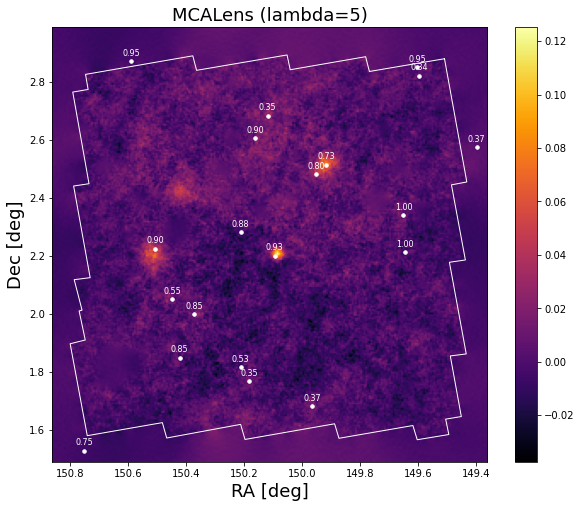

In [30]:
# MCAlens reconstruction with a 5sigma detection
k1r5,k1i5,k2r5,k2i = M.sparse_wiener_filtering(D, ps1d, Nsigma=5, Inpaint=Inpaint, Bmode=Bmode, ktr=None)
tvradec(k1r5, title='MCALens (lambda=5)',lut=lut,xclus=xclus,ztext=ztext,m500min=m500min)